# Sprint24 Seq2Seq

# 【問題1】機械翻訳の実行とコードリーディング
以下のサンプルコードは、短い英語からフランス語への変換を行うものです。これを動かしてください。


keras/lstm_seq2seq.py at master · rstudio/keras


その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめてください。以下のようにどこからどこの行が何をしているかを記述してください。

In [11]:
'''Sequence to sequence example in Keras (character-level).
This script demonstrates how to implement a basic character-level
sequence-to-sequence model. We apply it to translating
short English sentences into short French sentences,
character-by-character. Note that it is fairly unusual to
do character-level machine translation, as word-level
models are more common in this domain.
# Summary of the algorithm:
- We start with input sequences from a domain (e.g. English sentences)
    and correspding target sequences from another domain
    (e.g. French sentences).
- An encoder LSTM turns input sequences to 2 state vectors
    (we keep the last LSTM state and discard the outputs).
- A decoder LSTM is trained to turn the target sequences into
    the same sequence but offset by one timestep in the future,
    a training process called "teacher forcing" in this context.
    Is uses as initial state the state vectors from the encoder.
    Effectively, the decoder learns to generate `targets[t+1...]`
    given `targets[...t]`, conditioned on the input sequence.
- In inference mode, when we want to decode unknown input sequences, we:
    - Encode the input sequence into state vectors
    - Start with a target sequence of size 1
        (just the start-of-sequence character)
    - Feed the state vectors and 1-char target sequence
        to the decoder to produce predictions for the next character
    - Sample the next character using these predictions
        (we simply use argmax).
    - Append the sampled character to the target sequence
    - Repeat until we generate the end-of-sequence character or we
        hit the character limit.
# Data download:
English to French sentence pairs.
https://www.manythings.org/anki/fra-eng.zip
Lots of neat sentence pairs datasets can be found at:
https://www.manythings.org/anki/
# References:
- Sequence to Sequence Learning with Neural Networks
    https://arxiv.org/abs/1409.3215
- Learning Phrase Representations using
    RNN Encoder-Decoder for Statistical Machine Translation
    https://arxiv.org/abs/1406.1078
'''
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

#各種パラメータ設定
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
data_path = 'fra-eng/fra.txt'

# Vectorize the data.
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
lines = open(data_path).read().split('\n')

#テキストファイルを代入
for line in lines[: min(num_samples, len(lines) - 1)]:
    input_text, target_text = line.split('\t')[:2] #[:2]を書くことでエラー解消（2つ目以降の文字列は無視）
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = '\t' + target_text + '\n'
    input_texts.append(input_text)
    target_texts.append(target_text)
    
    #inputとtargerの重複を排除している？
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

#データ整形
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

#キー：ユニークの文字列（アルファベットや数字や特殊文字）、値：インデックス　の辞書にまとめる
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

#zerosで箱作り
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

#デコーダとエンコーダをそれぞれワンホット化
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# シーケンスの定義
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# エンコーダアウトプットを切り捨て、ステートのみ保存する
encoder_states = [state_h, state_c]

# encoder_statesで、デコーダの初期値を設定.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

#モデルの定義
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

#プロセス作成
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

#学習
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)

#モデルを保存
model.save('s2s.h5')

# Next: inference mode (sampling).
# Here's the drill:
# 1) encode input and retrieve initial decoder state
# 2) run one step of decoder with this initial state
# and a "start of sequence" token as target.
# Output will be the next target token
# 3) Repeat with the current target token and current states

#
#ここからpredict
#

#手順2. 初期

# サンプリングモデルを定義する
encoder_model = Model(encoder_inputs, encoder_states)

#手順1. 入力データをエンコードし、デコーダーステートの初期値を取得
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())

#シーケンスのデコード関数
def decode_sequence(input_seq):
    # ステート行列としてエンコードする
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    #stop_condition（ループ制御）設定
    #
    stop_condition = False
    decoded_sentence = ''

    #
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        #トークンの抽出
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        #decoded_sentence（空、whileの前に定義）とsampled_charをマージ
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        # sampled_charが\n（改行）、もしくはdecoded_sentenceの長さがmax_decoder_seq_lengthの長さを上回った場合、stop_conditionをFalseにしループをストップさせる
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # target_seqの初期化とsampled_token_indexの配列3次元目への1変換
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # ステートの更新（decoder_model.predict時に取得しいたhとc）
        states_value = [h, c]

    return decoded_sentence


#predic精度の確認
for seq_index in range(100):
    #エンコードリストから1つのシーケンスを取得
    input_seq = encoder_input_data[seq_index: seq_index + 1]

    #1つのシーケンスをデコード
    decoded_sentence = decode_sequence(input_seq)

    #プリント（100回）
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 71
Number of unique output tokens: 92
Max sequence length for inputs: 15
Max sequence length for outputs: 59
Epoch 1/100
125/125 [==============================] - 7s 19ms/step - loss: 0.9771 - val_loss: 1.0671
Epoch 2/100
125/125 [==============================] - 2s 12ms/step - loss: 0.9108 - val_loss: 1.0164
Epoch 3/100
125/125 [==============================] - 2s 12ms/step - loss: 0.8646 - val_loss: 0.9909
Epoch 4/100
125/125 [==============================] - 2s 12ms/step - loss: 0.8260 - val_loss: 0.9401
Epoch 5/100
125/125 [==============================] - 2s 12ms/step - loss: 0.7953 - val_loss: 0.9124
Epoch 6/100
125/125 [==============================] - 2s 12ms/step - loss: 0.7694 - val_loss: 0.8984
Epoch 7/100
125/125 [==============================] - 2s 12ms/step - loss: 0.7480 - val_loss: 0.8380
Epoch 8/100
125/125 [==============================] - 2s 12ms/step - loss: 0.7280 - val_loss: 0.8194
Epoch 9/100
125/125

In [64]:
# for seq_index in range(100):
#     #エンコードリストから1つのシーケンスを取得
#     input_seq = encoder_input_data[seq_index + 100: seq_index + 101]

#     #1つのシーケンスをデコード
#     decoded_sentence = decode_sequence(input_seq)

#     #プリント（100回）
#     print('-')
#     print('Input sentence:', input_texts[seq_index])
#     print('Decoded sentence:', decoded_sentence)

print(input_seq.shape)
print(encoder_input_data.shape)

(1, 15, 71)
(10000, 15, 71)


In [67]:
# input_texts = []
# target_texts = []
# input_characters = set()
# target_characters = set()
# lines = open(data_path).read().split('\n')

len(target_texts)

10000

## 《文字単位のトークン化》


この実装ではテキストのベクトル化の際に、単語ではなく文字ごとを1つのトークンとして扱っています。


scikit-learnでBoWを計算するCountVectorizerの場合では、デフォルトの引数はanalyzer=’word’で単語を扱いますが、charやchar_wbとすることで文字を扱えるようになります。


charとchar_wbの2種類の方法があり、char_wbを指定した場合、n_gramが単語内からのみ作成されます。逆にcharは単語の区切りが関係なくn_gramが作成されます。This movie is very good.というテキストを3-gramでカウントする時、charではs mやe iといった単語をまたぐ数え方もしますが、char_wbではこれらを見ません。

# 【問題2】イメージキャプショニングの学習済みモデルの実行
上記実装において 5. Test the model の項目を実行してください。また、自身で用意した画像に対しても文章を生成してください。これらに対してどういった文章が出力されたかを記録して提出してください。


データセットからの学習は行わず、学習済みの重みをダウンロードして利用します。


注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっています。ここは書き換える必要があります。

In [38]:
# イメージキャプショニング（Image to Sequence)
# 1. Clone the repositories
# pytorch-tutorial/tutorials/03-advanced/image_captioning/
# https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning

# 1. Clone the repositories
# git clone https://github.com/pdollar/coco.git
# cd coco/PythonAPI/
# make
# python setup.py build
# python setup.py install
# cd ../../
# git clone https://github.com/yunjey/pytorch-tutorial.git
# cd pytorch-tutorial/tutorials/03-advanced/image_captioning/

# 2. Download the dataset
# pip install -r requirements.txt
# chmod +x download.sh
# ./download.sh
# 課題時は学習済みモデルを使用

# 3. Preprocessing
# !python build_vocab.py
# !python resize.py

# 4. Train the model
# !python train.py

# 5. Test the model
!python sample.py --image='png/cross_road.jpg'

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
<start> a group of people walking down a street . <end>


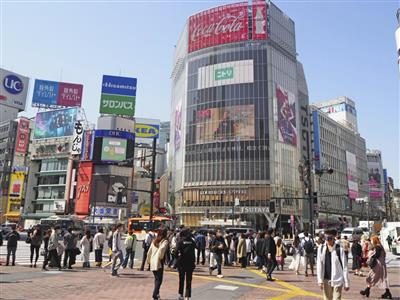

# 【問題3】Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしましたが、何らかの理由からKerasで動かしたい状況が考えられます。どういった手順を踏むことになるか調査し、できるだけ詳しく説明してください。


特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れてください。

## MMdnnを使用する

https://github.com/Microsoft/MMdnn

Microsoft Researchにより開発が進められているオープンソースの深層学習モデルの変換と可視化を行うツール。 中間表現を経由することで様々なフレームワーク間でのモデルデータの相互変換を実現しています。

https://qiita.com/koppe/items/7f85f5411539390c4499

MMdnnは、ユーザーがさまざまな深層学習フレームワーク間で相互運用できるようにするためのツールのセットです。たとえば、モデルの変換と視覚化。Caffe、Keras、MXNet、Tensorflow、CNTK、PyTorch Onnx、CoreMLの間でモデルを変換します。

以下のフレームワークでモデルの相互運用が可能 Caffe、Keras、Tensorflow、CNTK、MXNet、PyTorch、CoreML

mmconvert -sf pytorch -iw imagenet_inception_v3.h5 -df keras -om imagenet_inception_v3.onnx